In [1]:
!pip install torchvision matplotlib numpy tensorboard standard-imghdr torchnet scikit-learn opencv-python Levenshtein pycm


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from PIL import Image, ImageDraw, ImageFont
from sklearn.metrics import accuracy_score
from torch.utils.tensorboard import SummaryWriter
from ImageToStringNet import ImageToStringNet, classes
import pandas as pd
import Levenshtein
import sys
from torch.utils.data import random_split, DataLoader, Subset
from pycm import ConfusionMatrix
import json
import os
import random
from torchvision import transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Dataset loader

In [3]:
print("Classes: ", len(classes))

class DigitDataset(Dataset):
    def __init__(self, imgs_path, txt_path, transform=None):
        self.imgs_path = imgs_path
        self.images = np.loadtxt(txt_path, dtype=str, delimiter='\t', comments=[])
        self.transform = transform
        self.targets = [classes.index(c) for _, c, _, _ in self.images]
        self.targets = torch.LongTensor(self.targets)
        
        self.data = [Image.open(f'{self.imgs_path}/{i}').convert('L') for i, _, _, _ in self.images]
        self.data = [self.transform(i) for i in self.data]
        self.data = torch.stack(self.data, dim=0)

    def __getitem__(self, index):
        _, _, t, b = self.images[index]

        # Image Tensor, Label, Top Margin (%), Bottom Margin (%)
        return self.data[index], self.targets[index], np.float32(t), np.float32(b)

    def __len__(self):
        return len(self.images)

Classes:  96


In [4]:
batch_size = 16

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

In [5]:
# ---- impostazioni ----
dataset_dir = "../dataset/digit_dataset"
train_txt   = os.path.join(dataset_dir, "train.txt")
test_txt    = os.path.join(dataset_dir, "test.txt")

with open(train_txt, 'r') as f:
    lines = f.read().splitlines()

font_to_indices = {}
for idx, line in enumerate(lines):
    font_name = line.split()[0].split('/')[0]
    font_to_indices.setdefault(font_name, []).append(idx)

# ---- 2) split 80/20 sui font ----
random.seed(1234)
all_fonts = list(font_to_indices.keys())
random.shuffle(all_fonts)

n_train_fonts = int(0.8 * len(all_fonts))
train_fonts = set(all_fonts[:n_train_fonts])
val_fonts   = set(all_fonts[n_train_fonts:])

train_idxs = []
val_idxs   = []
for font, idx_list in font_to_indices.items():
    if font in train_fonts:
        train_idxs.extend(idx_list)
    else:
        val_idxs.extend(idx_list)

train, validation, test loader

In [6]:
trainset = DigitDataset(imgs_path=dataset_dir,
                        txt_path=train_txt,
                        transform=transforms.ToTensor())
testset  = DigitDataset(imgs_path=dataset_dir,
                        txt_path=test_txt,
                        transform=transforms.ToTensor())

train_subset = Subset(trainset, train_idxs)
val_subset   = Subset(trainset, val_idxs)


trainloader = torch.utils.data.DataLoader(train_subset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)
valloader = torch.utils.data.DataLoader(val_subset,
                                        batch_size=batch_size,
                                        shuffle=False,
                                        num_workers=2)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=2)

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Network Setup

In [7]:
net = ImageToStringNet(dropout_rate=0.5)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [9]:
dataiter = iter(trainloader)
next(dataiter)[0].shape

torch.Size([16, 1, 28, 28])

In [10]:
writer = SummaryWriter(f'runs/demo')

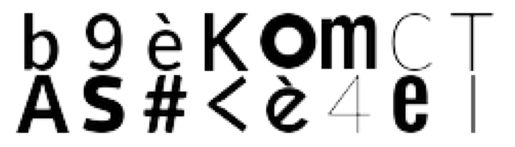

In [11]:
dataiter = iter(trainloader)
images, labels, t, b = next(dataiter)
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
writer.add_image('four_img-to-str_images', img_grid)

In [12]:
writer.add_graph(net, (images, t, b))
writer.close()

shapes

In [13]:
def select_n_random(data, labels, n=100):
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(trainset.data, trainset.targets)
print("Images shape: ", images.shape)
print("Labels shape: ", labels.shape)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images)
writer.close()

Images shape:  torch.Size([100, 1, 28, 28])
Labels shape:  torch.Size([100])


In [14]:
def images_to_probs(net, images, top_margin, bottom_margin):
    output = net(images, top_margin, bottom_margin)

    output = output.cpu()

    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels, top_margin, bottom_margin):
    preds, probs = images_to_probs(net, images, top_margin, bottom_margin)
    # plot the images in the batch, along with predicted and true labels

    images = images.cpu()

    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [15]:
class AverageValueMeter():
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.sum = 0
        self.num = 0
    
    def add(self, value, num):
        self.sum += value * num
        self.num += num
    
    def value(self):
        try:
            return self.sum / self.num
        except:
            return None

In [ ]:
loss_meter = AverageValueMeter()
accuracy_meter = AverageValueMeter()

epochs = 15

loader = {
    'train': trainloader,
    'val': valloader,
    'test': testloader
}

load configurazioni di validation

In [17]:
with open('validation_parameters.json', 'r') as f:
    configurations = json.load(f)

configurations[:5]

[{'learning_rate': 0.005, 'dropout': 0.3, 'momentum': 0.9},
 {'learning_rate': 0.005, 'dropout': 0.4, 'momentum': 0.0},
 {'learning_rate': 0.005, 'dropout': 0.4, 'momentum': 0.5},
 {'learning_rate': 0.005, 'dropout': 0.4, 'momentum': 0.9},
 {'learning_rate': 0.005, 'dropout': 0.5, 'momentum': 0.0}]

# Training

In [25]:
configurations = [
	{
		"start_epoch": 0,
		"run_name_prefix": "exps7",
		# "weight_name": "exps7",
        "learning_rate": 0.02,
        "dropout": 0.5,
        "momentum": 0.5
    }
]

In [26]:
torch.xpu.is_available = lambda: False

In [ ]:
results = []

for conf in configurations:
    # Istanzia la rete neurale con il corrente dropout
    net = ImageToStringNet(dropout_rate=conf['dropout'])
    
    net = net.xpu() if torch.xpu.is_available() else net

    optimizer = optim.SGD(net.parameters(), lr=conf['learning_rate'], momentum=conf['momentum'])

    # Writer tensorboard per l'esperimento corrente
    run_name = f"lr{conf['learning_rate']}_drop{conf['dropout']}_momentum{conf['momentum']}"
    if "run_name_prefix" not in conf:
        conf["run_name_prefix"] = "exps"
    writer = SummaryWriter(f'runs/{conf["run_name_prefix"]}_{run_name}')

    # Percorso pesi
    weights_name = conf.get("weight_name", f'{run_name}') + '.pth'
    weights_path = f'./weights/{weights_name}'

    # Se esistono pesi salvati, li carica nel modello
    if os.path.exists(weights_path):
        print("Loading existing weights")
        net.load_state_dict(torch.load(weights_path, weights_only=True))
    print('=============================================================')
    print("CONFIGURAZIONE: ", conf)

    # Uno step per ogni epoca
    global_step = conf.get("start_epoch", 0)
    for epoch in range(conf.get("start_epoch", 0), conf.get("start_epoch", 0) + epochs):
        print(f'\nEpoca {epoch + 1}')
        global_step += 1

        for mode in ["train", "val"]:
            loss_meter.reset()
            accuracy_meter.reset()

            # Itera sui dati del dataloader (train o val)
            for i, data in enumerate(loader[mode]):
                with torch.set_grad_enabled(mode == "train"):
                    inputs, labels, t, b = data
                    if torch.xpu.is_available():
                        inputs, labels, t, b = inputs.xpu(), labels.xpu(), t.xpu(), b.xpu()

                    if mode == "val":
                        net.eval()  # modalità valutazione

                    # Esecuzione forward
                    outputs = net(inputs, t, b)
                    loss = criterion(outputs, labels)

                    if mode == "train":
                        # Backpropagation e ottimizzazione
                        loss.backward()
                        optimizer.step()
                        optimizer.zero_grad()

                    # Aggiorna metriche di loss e accuratezza
                    loss_meter.add(loss.item(), inputs.size(0))
                    accuracy_meter.add(accuracy_score(labels.cpu(), outputs.cpu().max(1)[1]), inputs.size(0))

            # Scrive su TensorBoard i valori di loss e accuracy
            writer.add_scalar(f'loss/{mode}', loss_meter.value(), global_step)
            writer.add_scalar(f'accuracy/{mode}', accuracy_meter.value(), global_step)

            print(f'\t[{mode}]\tLoss: {loss_meter.value():.4f}, Accuracy: {accuracy_meter.value():.4f}')

        # Aggiunge una figura su TensorBoard con le predizioni vs etichette reali
        # writer.add_figure('predictions vs. actuals',
        #                   plot_classes_preds(net, inputs, labels, t, b),
        #                   global_step)
        torch.save(net.state_dict(), weights_path.replace('.pth', f'_{epoch}.pth'))
        
    # Salva i pesi del modello a fine allenamento
    torch.save(net.state_dict(), weights_path)

    print('=============================================================')



CONFIGURAZIONE:  {'start_epoch': 0, 'run_name_prefix': 'exps7', 'learning_rate': 0.02, 'dropout': 0.5, 'momentum': 0.5}

Epoca 1
	[train]	Loss: 1.6900, Accuracy: 0.5234
	[val]	Loss: 0.7442, Accuracy: 0.7687

Epoca 2
	[train]	Loss: 0.1603, Accuracy: 0.9285
	[val]	Loss: 1.0067, Accuracy: 0.8237

Epoca 3
	[train]	Loss: 0.0920, Accuracy: 0.9595
	[val]	Loss: 1.2501, Accuracy: 0.8249

Epoca 4
	[train]	Loss: 0.0660, Accuracy: 0.9713
	[val]	Loss: 1.4064, Accuracy: 0.8232

Epoca 5
	[train]	Loss: 0.0488, Accuracy: 0.9783
	[val]	Loss: 1.6200, Accuracy: 0.8135

Epoca 6
	[train]	Loss: 0.0420, Accuracy: 0.9818
	[val]	Loss: 1.6803, Accuracy: 0.8154

Epoca 7
	[train]	Loss: 0.0333, Accuracy: 0.9849
	[val]	Loss: 1.7582, Accuracy: 0.8154

Epoca 8
	[train]	Loss: 0.0304, Accuracy: 0.9866
	[val]	Loss: 1.7674, Accuracy: 0.8083

Epoca 9
	[train]	Loss: 0.0243, Accuracy: 0.9886
	[val]	Loss: 1.9985, Accuracy: 0.8190

Epoca 10
	[train]	Loss: 0.0267, Accuracy: 0.9881
	[val]	Loss: 1.8954, Accuracy: 0.8095

Epoca 1

# Evaluation

In [31]:
final_weights = '../src/weights/lr0.02_drop0.5_momentum0.5_4.pth'
final_dropout = 0.5

In [32]:
net = ImageToStringNet(dropout_rate=final_dropout)
net.load_state_dict(torch.load(final_weights, weights_only=True))

if torch.xpu.is_available():
    net = net.xpu()

In [33]:
net

ImageToStringNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=258, out_features=120, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=84, out_features=96, bias=True)
  )
)

## Scores

In [34]:
loss_meter = AverageValueMeter()
accuracy_meter = AverageValueMeter()

all_preds = []
all_labels = []

net.eval()

with torch.no_grad():
    for data in testloader:
        inputs, labels, t, b = data

        outputs = net(inputs, t, b)
        loss = criterion(outputs, labels)

        preds = outputs.argmax(dim=1)

        loss_meter.add(loss.item(), inputs.size(0))
        accuracy_meter.add(accuracy_score(labels.cpu(), preds.cpu()), inputs.size(0))

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

print(f"Loss: {loss_meter.value():.4f}")
print(f"Accuracy: {accuracy_meter.value():.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1: {f1:.4f}")

Loss: 1.0888
Accuracy: 0.8567
Precision: 0.8664
Recall: 0.8620
F1: 0.8520


## PR-curves

In [35]:
net.eval()

writer = SummaryWriter(f'runs/exps5')
with torch.no_grad():

    all_inputs = []
    all_labels = []
    all_t = []
    all_b = []

    for inputs, labels, t, b in testloader:
        all_inputs.append(inputs)
        all_labels.append(labels)
        all_t.append(t)
        all_b.append(b)

    # Concatenate all the collected tensors
    inputs = torch.cat(all_inputs, dim=0)
    labels = torch.cat(all_labels, dim=0)
    t = torch.cat(all_t, dim=0)
    b = torch.cat(all_b, dim=0)

    # Now you have a single, merged batch
    outputs = net(inputs, t, b)
    loss = criterion(outputs, labels)

    writer.add_figure('predictions vs. actuals', plot_classes_preds(net, inputs, labels, t, b), 0)


In [36]:
class_probs = []
class_label = []
with torch.no_grad():
    for data in testloader:
        images, labels, t, b = data

        if torch.xpu.is_available():
            images, t, b = images.xpu(), t.xpu(), b.xpu()

        output = net(images, t, b)
        output = output.cpu()

        class_probs_batch = [F.softmax(el, dim=0) for el in output]

        class_probs.append(class_probs_batch)
        class_label.append(labels)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_label = torch.cat(class_label)

new_classes = sorted(list(set(c.lower() for c in classes)))
old_to_new_class_mapping = {
    old_idx: new_classes.index(old_class.lower())
    for old_idx, old_class in enumerate(classes)
}
remapped_test_label = torch.tensor([old_to_new_class_mapping[l.item()] for l in test_label], dtype=torch.long)

num_new_classes = len(new_classes)
num_samples = test_probs.shape[0]
remapped_test_probs = torch.zeros(num_samples, num_new_classes)

for old_idx, probs_for_old_class in enumerate(test_probs.T):
    new_idx = old_to_new_class_mapping[old_idx]
    remapped_test_probs[:, new_idx] += probs_for_old_class

def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    '''
    Takes in a "class_index" from 0 to len(new_classes)-1 and plots the corresponding
    precision-recall curve.
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    tag = new_classes[class_index] if not new_classes[class_index].isalpha() else (new_classes[class_index] + "/" + new_classes[class_index].upper())

    print("Tag:", tag)
    writer.add_pr_curve(tag,
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

for i in range(len(new_classes)):
    if new_classes[i].isalpha():
        add_pr_curve_tensorboard(i, remapped_test_probs, remapped_test_label)

Tag: a/A
Tag: b/B
Tag: c/C
Tag: d/D
Tag: e/E
Tag: f/F
Tag: g/G
Tag: h/H
Tag: i/I
Tag: j/J
Tag: k/K
Tag: l/L
Tag: m/M
Tag: n/N
Tag: o/O
Tag: p/P
Tag: q/Q
Tag: r/R
Tag: s/S
Tag: t/T
Tag: u/U
Tag: v/V
Tag: w/W
Tag: x/X
Tag: y/Y
Tag: z/Z
Tag: à/À
Tag: è/È
Tag: é/É
Tag: ì/Ì
Tag: ò/Ò
Tag: ù/Ù


## Confusion matrix

In [40]:
ground_truth = []
results = []
results_insenstive = []

net.eval()

with torch.no_grad():
    for data in testloader:
        inputs, labels, t, b = data

        outputs = net(inputs, t, b)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs, 1)
        results.extend([classes[pred] for pred in predicted])
        results_insenstive.extend([classes[pred].upper() for pred in predicted])


        ground_truth.extend([classes[label] for label in labels])


In [41]:
cm = ConfusionMatrix(actual_vector=ground_truth, predict_vector=results)

cm.save_html("../docs/assets/confusion_matrix_report", color=(100, 150, 255))  # Blu chiaro

{'Status': True,
 'Message': '/home/teogalletta/Documents/university-ml-imgtostr/src/../docs/assets/confusion_matrix_report.html'}

In [42]:
cm = ConfusionMatrix(actual_vector=[x.upper() for x in ground_truth], predict_vector=results_insenstive)

cm.save_html("../docs/assets/confusion_matrix_report_upper", color=(100, 150, 255))  # Blu chiaro

{'Status': True,
 'Message': '/home/teogalletta/Documents/university-ml-imgtostr/src/../docs/assets/confusion_matrix_report_upper.html'}